In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cofactor.features import Features
from cofactor.model import LatticePredictor
from cofactor.calculator import CofactorCalculator

In [3]:
featgen = Features.from_excel('data/elemental.xlsx')
model = LatticePredictor.from_file('models/model.pkl')
data = pd.read_csv('data/lattices.csv', index_col=0)

In [84]:
def features_from_df(df, element):
    df['T0'] = df['T0 (K)'] - 273
    df['x'] = to_mol_percent(df, element)
    
    inputs = {
        element: df.x.values.reshape(-1, 1),
        'Zr': 1 - df.x.values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1)
    }
    X = featgen.get_features(inputs, model.features)
    
    return X

def get_cofactors(X, model):
    cofactors = []
    for tetr, mono in model.predict_lattice(X[model.features]):
        calc = CofactorCalculator(tetr, mono)
        cofactors.append(calc.get_cofactors())

    return pd.concat([X, pd.DataFrame(cofactors)], axis=1)

def get_gradient(results, element):
    grad_dilute = results[[element, 'T', 'B']][:2].diff().iloc[-1]
    
    dT_dx = grad_dilute['T'] / grad_dilute[element]
    dL_dx = grad_dilute['B'] / grad_dilute[element]
    
    return dT_dx, dL_dx

def to_mol_percent(df, element):
    x = df.iloc[:, 0] / 100

    s = df.columns[0]
    num = re.findall(element + '(\d)O', s)
    if len(num) == 0:
        return x

    return x / (int(num[0]) - x)

### Design charts

In [89]:
UNCERTAINTY_LAMBDA = 0.001145

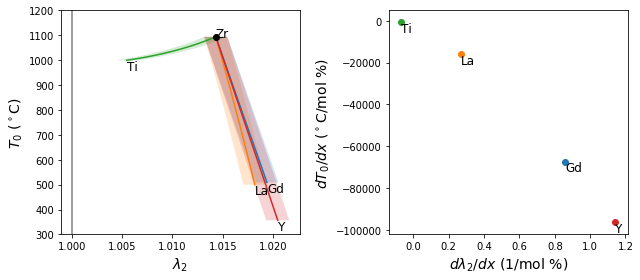

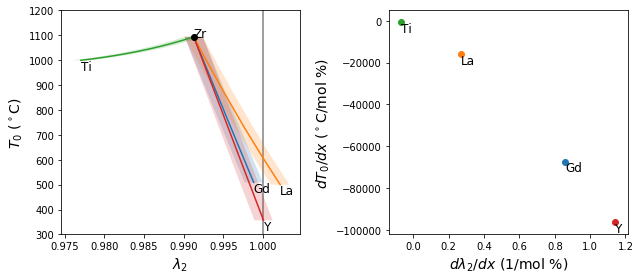

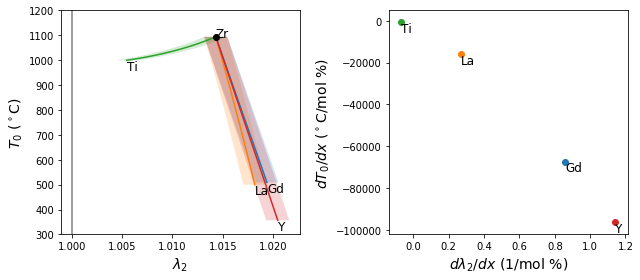

In [91]:
for corresp in ['A', 'B', 'C']:
    files = sorted(os.listdir('data/t0'))
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    for file in files:
        element = file.strip('.csv')
        df = pd.read_csv(os.path.join('data/t0', file))
        X = features_from_df(df, element)
        results = get_cofactors(X, model)
        results = results.sort_values(element)

        ax[0].plot(results[corresp], results['T'], label=element)
        ax[0].fill_betweenx(
            results['T'],
            results[corresp] - UNCERTAINTY_LAMBDA,
            results[corresp] + UNCERTAINTY_LAMBDA,
            alpha=0.2
        )
        ax[0].annotate(element, (results[corresp].values[-1], results['T'].values[-1]), fontsize=12, va='top')

        dT, dL = get_gradient(results, element)
        ax[1].scatter(dL, dT)
        ax[1].annotate(element, (dL, dT), fontsize=12, va='top')

    ax[0].scatter([results[corresp].values[0]], [results['T'].values[0]], zorder=3, color='k')
    ax[0].annotate('Zr', (results[corresp].values[0], results['T'].values[0]), fontsize=12)

    ax[0].set_xlabel(r'$\lambda_2$', fontsize=14)
    ax[0].set_ylabel(r'$T_0$ ($^\circ$C)', fontsize=14)

    ylim = (300, 1200)
    ax[0].set_ylim(ylim)
    ax[0].plot([1, 1], ylim, color='#808080', zorder=-1)

    ax[1].set_xlabel(r'$d\lambda_2/dx$ (1/mol %)', fontsize=14)
    ax[1].set_ylabel(r'$dT_0/dx$ ($^\circ$C/mol %)', fontsize=14)


    # ax.legend()
    fig.tight_layout()
    plt.show()